### Loads

In [1]:
import pandas as pd
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
import pickle
import numpy as np

### Count positives, negatives, neutrals and both

In [2]:
train_aspects = pd.read_csv(
    'train_aspects.txt',
    delimiter='\t',
    names=['text_id', 'category', 'mention', 'start', 'end', 'sentiment'])

train_cats = pd.read_csv(
    'train_cats.txt',
    delimiter='\t',
    names=['text_id', 'category', 'sentiment'])

In [3]:
test_aspects = pd.read_csv(
    'dev_aspects.txt',
    delimiter='\t',
    names=['text_id', 'category', 'mention', 'start', 'end', 'sentiment'])

test_cats = ''

In [4]:
CATEGORIES = ['Food', 'Interior', 'Price', 'Whole', 'Service']

In [5]:
def count(aspects, cats, train):
    text_ids = aspects['text_id'].unique()

    new_entry = {}
    entries = []
    for text_id in text_ids:
        for c in CATEGORIES:
            positive = 0
            negative = 0
            neutral = 0
            both = 0

            if not aspects[(aspects['text_id']==text_id) & (aspects['category']==c)]['category'].empty:
                for i in range(len(aspects[(aspects['text_id']==text_id) & (aspects['category']==c)]['sentiment'])):
                    if aspects[(aspects['text_id']==text_id) & (aspects['category']==c)]['sentiment'].iloc[i] == 'positive':
                        positive += 1
                    elif aspects[(aspects['text_id']==text_id) & (aspects['category']==c)]['sentiment'].iloc[i] == 'negative':
                        negative += 1
                    elif aspects[(aspects['text_id']==text_id) & (aspects['category']==c)]['sentiment'].iloc[i] == 'neutral':
                        neutral += 1
                    elif aspects[(aspects['text_id']==text_id) & (aspects['category']==c)]['sentiment'].iloc[i] == 'both':
                        both += 1

            if train:
                new_entry = {'text_id': text_id, 'category': c, 'sentiment': cats[(cats['text_id'] == text_id) & (cats['category'] == c)]['sentiment'].iloc[0], 'positive': positive, 'negative': negative, 'neutral': neutral, 'both': both}
            else:
                new_entry = {'text_id': text_id, 'category': c, 'positive': positive, 'negative': negative, 'neutral': neutral, 'both': both}
            entries.append(new_entry)
    df = pd.DataFrame.from_records(entries)
    return df

In [6]:
train = count(train_aspects, train_cats, True)
train

,text_id,category,sentiment,positive,negative,neutral,both
0,30808,Food,positive,2,0,0,0
1,30808,Interior,positive,1,0,1,0
2,30808,Price,positive,1,0,0,0
3,30808,Whole,positive,2,0,1,0
4,30808,Service,positive,4,0,0,0
...,...,...,...,...,...,...,...
1060,16630,Food,positive,1,0,0,0
1061,16630,Interior,positive,1,0,0,0
1062,16630,Price,absence,0,0,0,0
1063,16630,Whole,positive,2,0,0,0


In [7]:
test = count(test_aspects, test_cats, False)
test

,text_id,category,positive,negative,neutral,both
0,3976,Food,2,0,1,0
1,3976,Interior,4,0,0,0
2,3976,Price,0,0,0,0
3,3976,Whole,2,0,5,0
4,3976,Service,4,0,1,1
...,...,...,...,...,...,...
350,33043,Food,7,0,0,0
351,33043,Interior,3,1,0,0
352,33043,Price,0,0,0,0
353,33043,Whole,1,0,0,0


<Axes: xlabel='sentiment', ylabel='count'>

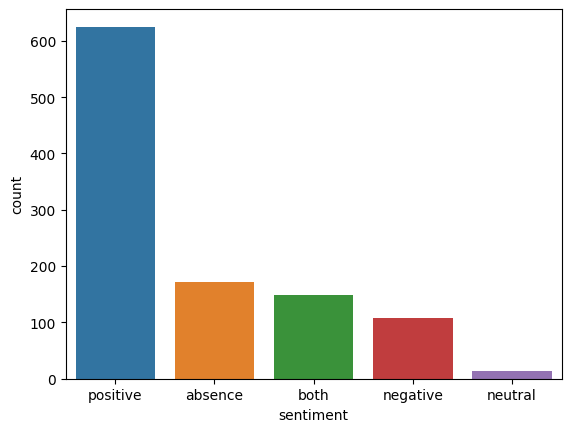

In [8]:
import seaborn as sns
sns.countplot(x = train['sentiment'], label='count')

### Logistic regression

In [9]:
X_train = train[list(train.keys()[3::])]

In [10]:
LE = preprocessing.LabelEncoder()
y_train = LE.fit_transform(train['sentiment'])

In [11]:
clf = LogisticRegression(random_state=42).fit(X_train, y_train)

In [12]:
y_pred = clf.predict(test[list(test.keys()[2::])])

In [13]:
new_test = test
y = LE.inverse_transform(y_pred)
new_test['sentiment'] = y
new_test.drop(['positive', 'negative', 'neutral', 'both'], axis=1, inplace=True)
new_test

,text_id,category,sentiment
0,3976,Food,positive
1,3976,Interior,positive
2,3976,Price,absence
3,3976,Whole,positive
4,3976,Service,positive
...,...,...,...
350,33043,Food,positive
351,33043,Interior,positive
352,33043,Price,absence
353,33043,Whole,positive


In [14]:
new_test.to_csv('dev_pred_cats.txt', sep='\t', header=False, index=False)

### Evaluation LR

In [15]:
gold_test_cats_path = "dev_cats.txt"
pred_test_cats_path = "dev_pred_cats.txt"

In [16]:
with open(gold_test_cats_path) as gc, open(pred_test_cats_path) as pc:
    gold_labels = set(gc.readlines())
    pred_labels = set(pc.readlines())
    print(
        "Overall sentiment accuracy:",
        len(gold_labels & pred_labels) / len(gold_labels)
    )

Overall sentiment accuracy: 0.8450704225352113


### Saving model

In [17]:
with open('lr_model.pkl', 'wb') as file:
    pickle.dump(clf, file)

In [18]:
np.save('classes.npy', LE.classes_)

### KNN

In [19]:
from sklearn.neighbors import KNeighborsClassifier

In [20]:
neigh = KNeighborsClassifier(n_neighbors=3)
neigh_clf = neigh.fit(X_train, y_train)

In [21]:
test = count(test_aspects, test_cats, False)
y_pred = neigh_clf.predict(test[list(test.keys()[2::])])

In [22]:
new_test = test
y = LE.inverse_transform(y_pred)
new_test['sentiment'] = y
new_test.drop(['positive', 'negative', 'neutral', 'both'], axis=1, inplace=True)
new_test

,text_id,category,sentiment
0,3976,Food,positive
1,3976,Interior,positive
2,3976,Price,absence
3,3976,Whole,positive
4,3976,Service,positive
...,...,...,...
350,33043,Food,positive
351,33043,Interior,positive
352,33043,Price,absence
353,33043,Whole,positive


In [23]:
new_test.to_csv('dev_pred_cats.txt', sep='\t', header=False, index=False)

### Evaluation KNN

In [24]:
gold_test_cats_path = "dev_cats.txt"
pred_test_cats_path = "dev_pred_cats.txt"

In [25]:
with open(gold_test_cats_path) as gc, open(pred_test_cats_path) as pc:
    gold_labels = set(gc.readlines())
    pred_labels = set(pc.readlines())
    print(
        "Overall sentiment accuracy:",
        len(gold_labels & pred_labels) / len(gold_labels)
    )

Overall sentiment accuracy: 0.8507042253521127
